In [1]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import statsmodels.api as sm

/Users/malenamalka/opt/anaconda3/lib/python3.9/site-packages/requests/__init__.py:113: RequestsDependencyWarning: urllib3 (1.26.11) or chardet (2.0.3)/charset_normalizer (2.0.4) doesn't match a supported version!
  warnings.warn(


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [51]:
#Week 1 work
start_date = '2020-01-01'
end_date = '2025-04-26'
sp500_data = yf.download('^GSPC', start=start_date, end=end_date, interval='1mo')
sp500_data.columns = sp500_data.columns.get_level_values(0)
sp500_data.head()

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Date,,,,,
2020-01-01,3225.520020,3337.770020,3214.639893,3244.669922,77287980000
2020-02-01,2954.219971,3393.520020,2855.840088,3235.659912,84436590000
2020-03-01,2584.590088,3136.719971,2191.860107,2974.280029,162185380000
2020-04-01,2912.429932,2954.860107,2447.489990,2498.080078,123608160000
2020-05-01,3044.310059,3068.669922,2766.639893,2869.090088,107135190000


In [52]:
sp500_data = sp500_data[['Close']].dropna()

sp500_data['Log Return'] = np.log(sp500_data['Close'] / sp500_data['Close'].shift(1))

sp500_data.dropna(inplace=True)

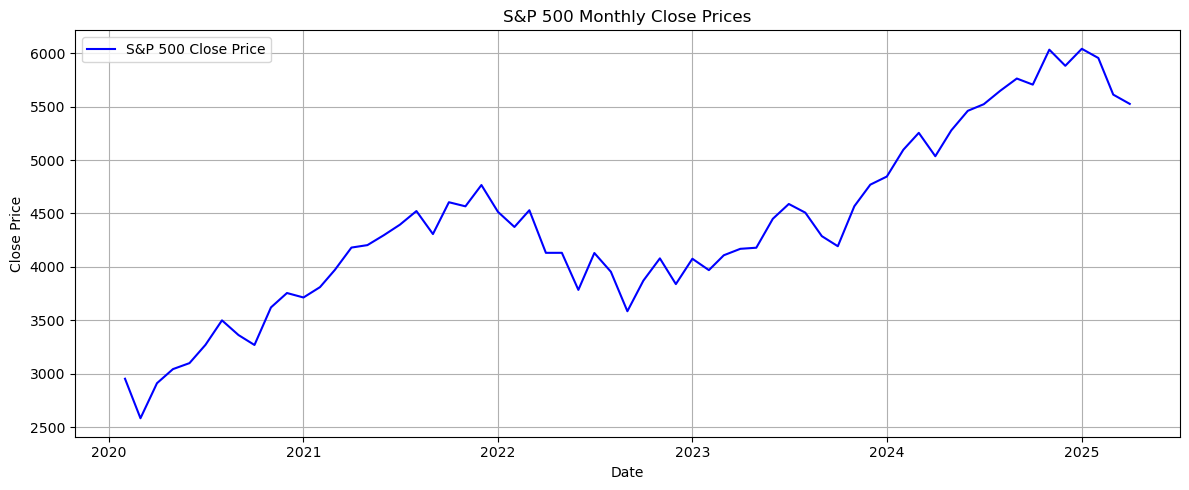

In [53]:
plt.figure(figsize=(12, 5))
plt.plot(sp500_data.index, sp500_data['Close'], label='S&P 500 Close Price', color='blue')
plt.title('S&P 500 Monthly Close Prices')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

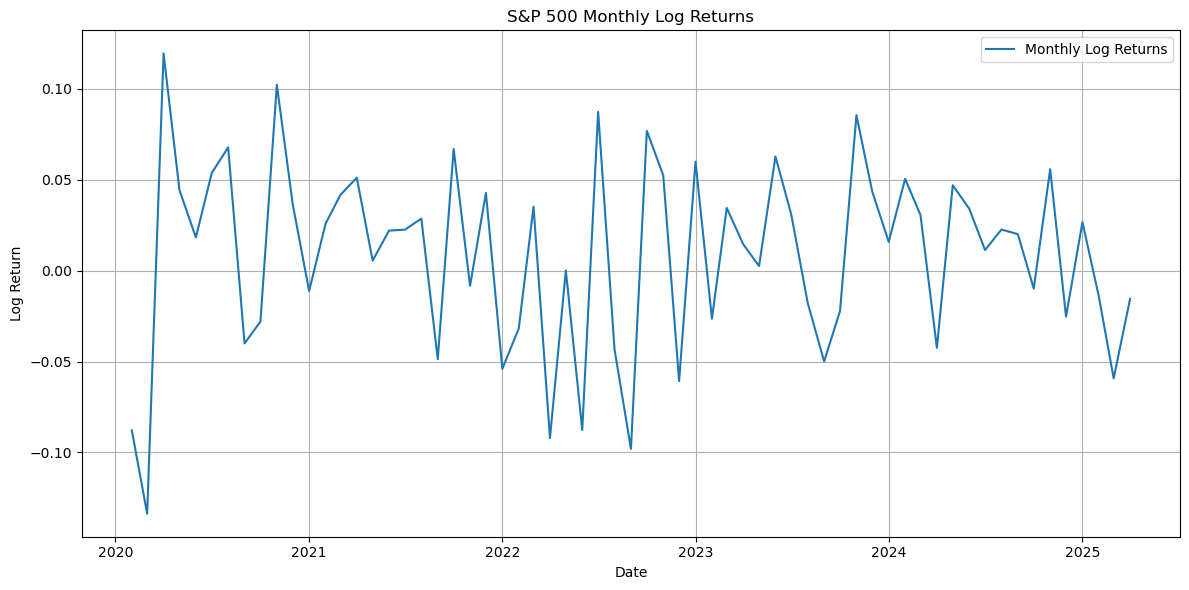

In [54]:
plt.figure(figsize=(12, 6))
plt.plot(sp500_data.index, sp500_data['Log Return'], label='Monthly Log Returns')
plt.title('S&P 500 Monthly Log Returns')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

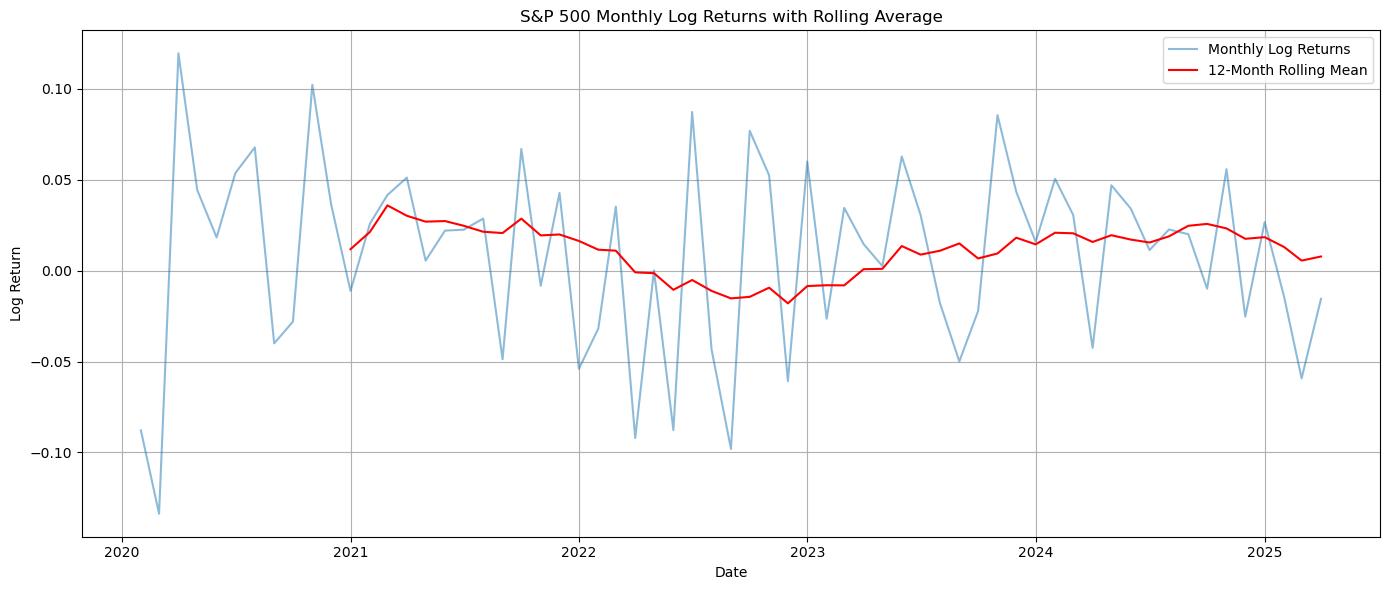

In [55]:
sp500_data['Rolling Mean'] = sp500_data['Log Return'].rolling(window=12).mean() 
#first 11 values are meant to be empty for rolling mean, don't get scared!
plt.figure(figsize=(14, 6))
plt.plot(sp500_data.index, sp500_data['Log Return'], label='Monthly Log Returns', alpha=0.5)
plt.plot(sp500_data.index, sp500_data['Rolling Mean'], label='12-Month Rolling Mean', color='red')
plt.title('S&P 500 Monthly Log Returns with Rolling Average')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

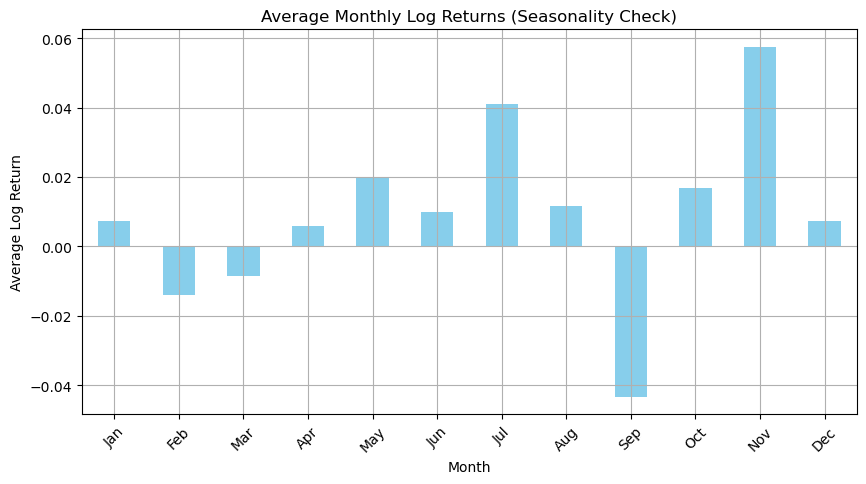

In [56]:
sp500_data['Month'] = sp500_data.index.month
monthly_avg = sp500_data.groupby('Month')['Log Return'].mean()

plt.figure(figsize=(10, 5))
monthly_avg.plot(kind='bar', color='skyblue')
plt.title('Average Monthly Log Returns (Seasonality Check)')
plt.xlabel('Month')
plt.ylabel('Average Log Return')
plt.xticks(ticks=range(0,12), labels=[
    'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)
plt.grid(True)
#plt.tight_layout()
plt.show()


<Figure size 1200x600 with 0 Axes>

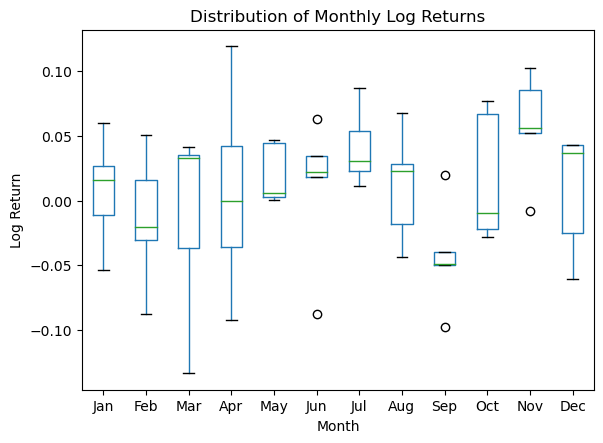

In [57]:
plt.figure(figsize=(12, 6))
sp500_data.boxplot(column='Log Return', by='Month', grid=False)
plt.title('Distribution of Monthly Log Returns')
plt.suptitle('')  # Hide default title
plt.xlabel('Month')
plt.ylabel('Log Return')
plt.xticks(ticks=range(1,13), labels=[
    'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
#plt.tight_layout()
plt.show()

In [58]:
# Week 2 work 

# ADF test on log returns

adf_result = adfuller(sp500_data['Log Return'])

print('ADF Statistic: %f' % adf_result[0])
print('p-value: %f' % adf_result[1])
print('Critical Values:')
for key, value in adf_result[4].items():
    print(f'\t{key}: {value}')

ADF Statistic: -8.941468
p-value: 0.000000
Critical Values:
	1%: -3.540522678829176
	5%: -2.9094272025108254
	10%: -2.5923136524453696


**Analysis:**

The ADF test statistic of -8.941 and the p-value of 0.000000 both indicate that the null hypothesis of a unit root can be rejected with strong confidence. This supports the conclusion that the log return time series is stationary, meaning it does not exhibit a persistent trend or non-stationary behavior. Since the test statistic is more negative than the 1% critical value (-3.541), we can reject the null hypothesis even at the strictest level of significance. This confirms that modeling the log returns without differencing is appropriate and aligns with the typical characteristics of financial return series.



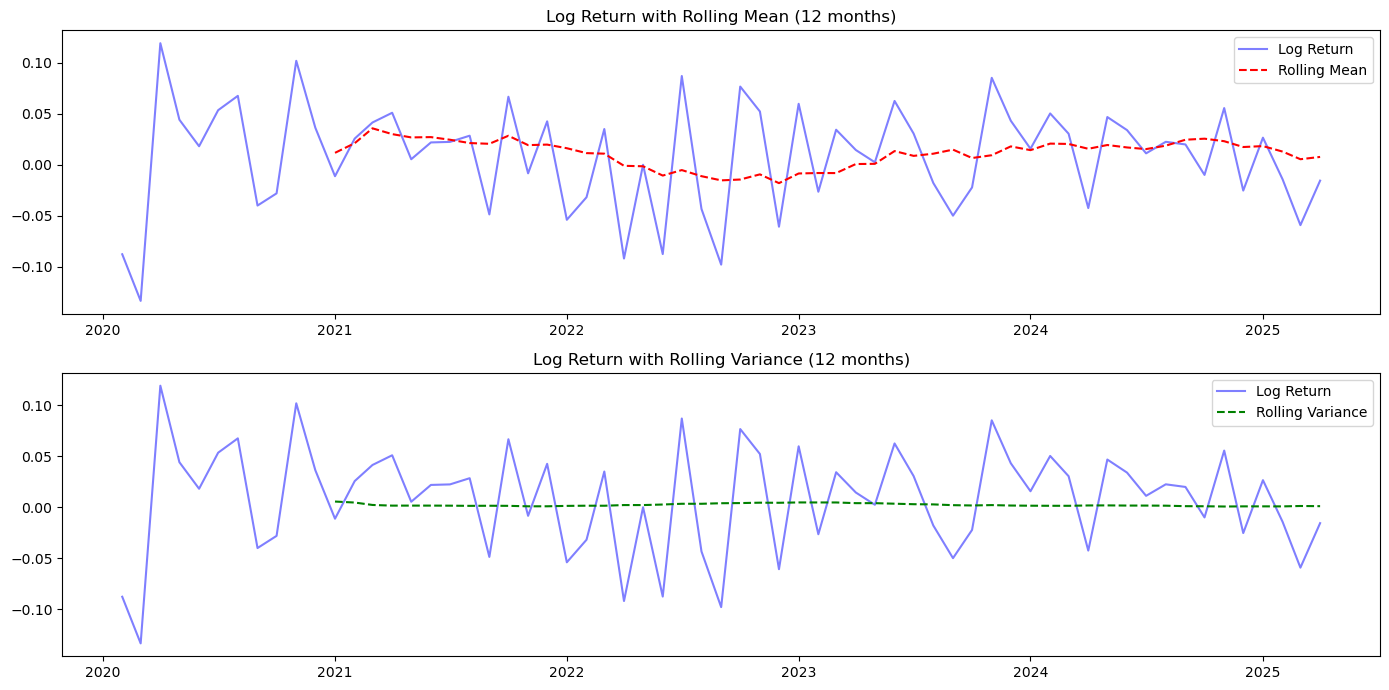

In [59]:
# rolling mean and rolling variance

window = 12

rolling_mean = sp500_data['Log Return'].rolling(window=window).mean()
rolling_variance = sp500_data['Log Return'].rolling(window=window).var()

plt.figure(figsize=(14, 7))

plt.subplot(2, 1, 1)
plt.plot(sp500_data.index, sp500_data['Log Return'], label='Log Return', color='blue', alpha=0.5)
plt.plot(rolling_mean, label='Rolling Mean', color='red', linestyle='--')
plt.title('Log Return with Rolling Mean (12 months)')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(sp500_data.index, sp500_data['Log Return'], label='Log Return', color='blue', alpha=0.5)
plt.plot(rolling_variance, label='Rolling Variance', color='green', linestyle='--')
plt.title('Log Return with Rolling Variance (12 months)')
plt.legend()

plt.tight_layout()
plt.show()

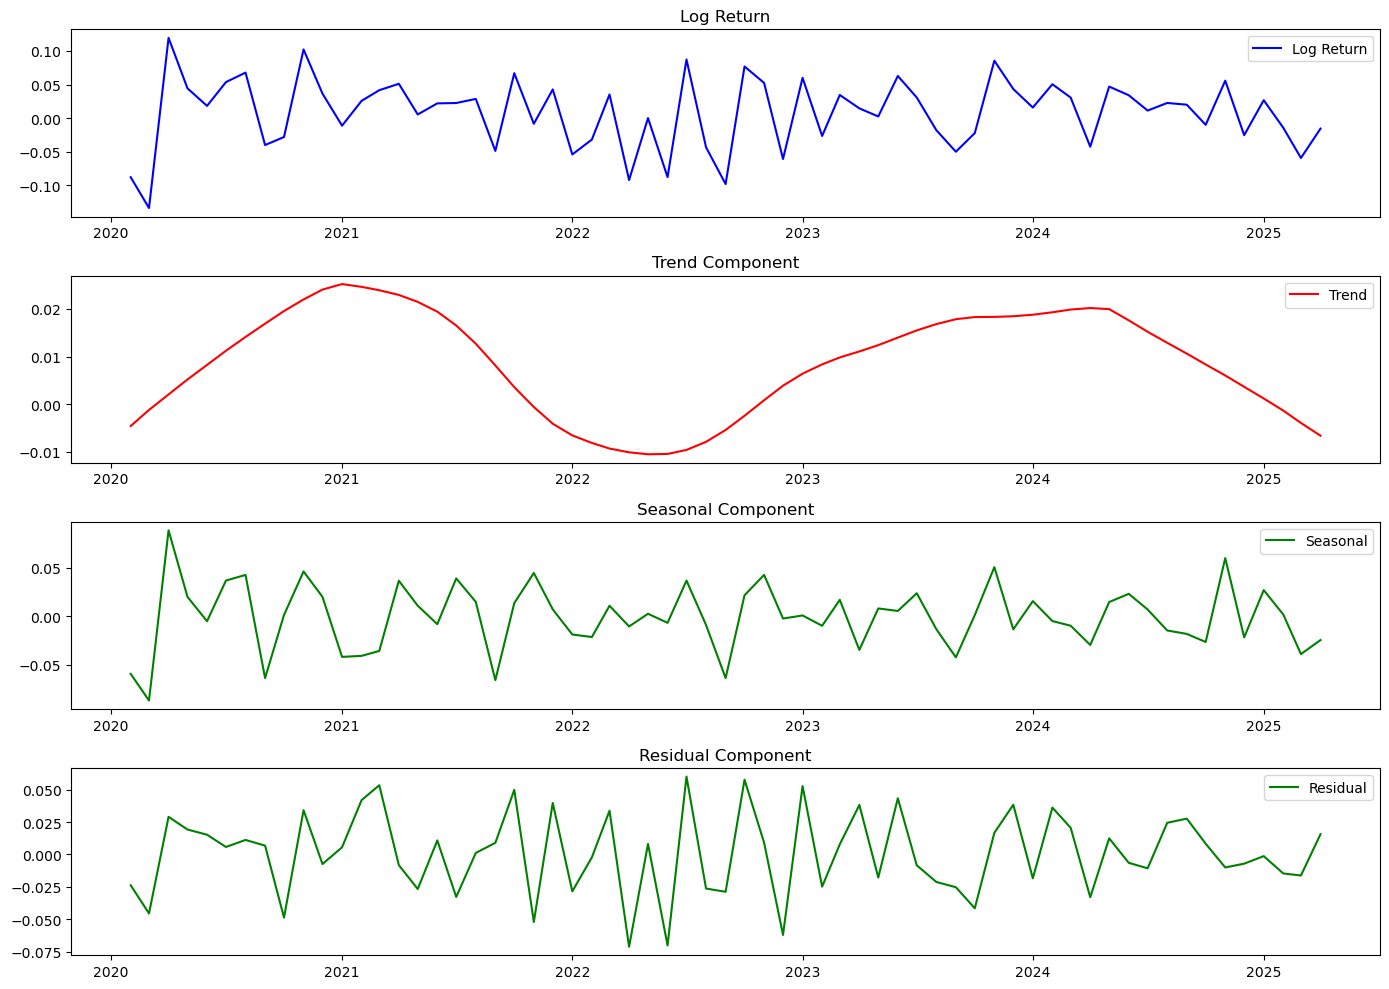

In [60]:
# perform STL decomposition on the log returns

stl = STL(sp500_data['Log Return'], period=12)
result = stl.fit()

seasonal = result.seasonal
trend = result.trend
residual = result.resid

plt.figure(figsize=(14, 10))

plt.subplot(4, 1, 1)
plt.plot(sp500_data.index, sp500_data['Log Return'], label='Log Return', color='blue')
plt.title('Log Return')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(sp500_data.index, trend, label='Trend', color='red')
plt.title('Trend Component')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(sp500_data.index, seasonal, label='Seasonal', color='green')
plt.title('Seasonal Component')
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(sp500_data.index, residual, label='Residual', color='green')
plt.title('Residual Component')
plt.legend()

plt.tight_layout()
plt.show()

In [61]:
arima_model = ARIMA(sp500_data['Log Return'], order=(1, 0, 1))
arima_result = arima_model.fit()
print("ARIMA Model Summary:")
print(arima_result.summary())

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:             Log Return   No. Observations:                   63
Model:                 ARIMA(1, 0, 1)   Log Likelihood                  97.895
Date:                Mon, 28 Apr 2025   AIC                           -187.790
Time:                        10:36:57   BIC                           -179.217
Sample:                    02-01-2020   HQIC                          -184.418
                         - 04-01-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0092      0.006      1.435      0.151      -0.003       0.022
ar.L1          0.2366      0.674      0.351      0.726      -1.085       1.558
ma.L1         -0.4023      0.64

**Analysis:**

The ARIMA(1, 0, 1) model results show the following:

Constant (const): The coefficient is 0.0092 with a p-value of 0.151, meaning it is not statistically significant. This suggests that the average monthly log return for this period is not meaningfully different from zero.

AR(1) coefficient: The coefficient is 0.2366 with a p-value of 0.726, meaning it is not statistically significant. This indicates that the previous month's return does not have a strong influence on the current return.

MA(1) coefficient: The coefficient is -0.4023 with a p-value of 0.535, meaning it is not statistically significant. This suggests that the first moving average term does not capture meaningful short-term error corrections.

Sigma2: The residual variance (σ²) is 0.0026 and is highly significant (p-value = 0.000), indicating that the model reliably estimates the variability of the residuals.

Ljung-Box (Q) test: The p-value of 0.81 indicates no significant autocorrelation remains in the residuals at lag 1, meaning the model adequately accounts for time-dependent structure.

Jarque-Bera (JB) test: The p-value of 0.04 suggests that the residuals are not perfectly normally distributed, with some left skewness (-0.78) and slight excess kurtosis (3.23), which are typical features in financial return series.

Heteroskedasticity (H): The p-value of 0.05 is right at the threshold of significance, suggesting some potential signs of heteroskedasticity, meaning volatility could vary slightly over time during this sample.



In [62]:
sarima_model = SARIMAX(sp500_data['Log Return'], order=(1, 0, 1), seasonal_order=(1, 0, 1, 12))
sarima_result = sarima_model.fit()
print("\nSARIMA Model Summary:")
print(sarima_result.summary())


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.51231D+00    |proj g|=  5.43905D+00

At iterate    5    f= -1.52644D+00    |proj g|=  3.59479D-01

At iterate   10    f= -1.53071D+00    |proj g|=  3.18906D-01

At iterate   15    f= -1.53080D+00    |proj g|=  4.92615D-02

At iterate   20    f= -1.53092D+00    |proj g|=  1.13709D-02

At iterate   25    f= -1.53281D+00    |proj g|=  4.01522D-01

At iterate   30    f= -1.53573D+00    |proj g|=  4.05933D-03

At iterate   35    f= -1.53582D+00    |proj g|=  4.34570D-02

At iterate   40    f= -1.54342D+00    |proj g|=  2.59747D-01

At iterate   45    f= -1.54410D+00    |proj g|=  3.28144D-02

At iterate   50    f= -1.54565D+00    |proj g|=  3.07480D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

Analysis:

The SARIMA(1, 0, 1)(1, 0, 1, 12) model results show the following:

AR(1) coefficient: The coefficient is 0.0453 with a p-value of 0.962, meaning it is not statistically significant. This suggests that the first lag of the series does not meaningfully influence current returns.

MA(1) coefficient: The coefficient is -0.1756 with a p-value of 0.852, meaning it is not statistically significant. This indicates that past errors do not meaningfully contribute to explaining current returns in this model.

Seasonal AR(12) coefficient: The coefficient is -0.7631 with a p-value of 0.286, meaning it is not statistically significant. There is no clear seasonal autoregressive effect at the 12-month lag.

Seasonal MA(12) coefficient: The coefficient is 0.9482 with a p-value of 0.521, meaning it is not statistically significant, and there is no strong seasonal moving average pattern.

Sigma2: The residual variance (σ²) is 0.0025, but it is not statistically significant (p-value = 0.248). Despite this, the variance estimate remains reasonable for modeling financial returns.

Ljung-Box (Q) test: The p-value of 0.87 suggests no significant autocorrelation remains in the residuals, meaning the model adequately captures the short-term dynamics of the data.

Jarque-Bera (JB) test: The p-value of 0.11 suggests that the residuals are approximately normally distributed, with mild left skewness (-0.64) and slight excess kurtosis (3.12), which is typical for financial returns.

Heteroskedasticity (H): The p-value of 0.02 indicates some evidence of heteroskedasticity, suggesting that volatility may not be constant over time in the residuals.

Comparison to ARIMA:

Comparing the two models, the ARIMA(1,0,1) model outperforms the SARIMA(1,0,1)(1,0,1,12) model for this period. ARIMA has a lower AIC (-187.790 vs. -184.752) and a slightly higher log-likelihood (97.895 vs. 97.376), indicating a better overall fit. Additionally, the SARIMA model's seasonal components are not statistically significant, meaning that adding seasonal terms does not provide meaningful improvements in explaining or forecasting the returns. Therefore, the simpler ARIMA(1,0,1) model is preferred for modeling log returns between 2020 and 2025.

In [63]:
# Ensure 'Month' column is category
sp500_data['Month'] = sp500_data.index.month.astype('category')

# Create dummy variables (January as baseline)
month_dummies = pd.get_dummies(sp500_data['Month'], drop_first=True)

# Regression setup
X = sm.add_constant(month_dummies)
y = sp500_data['Log Return']

reg_model = sm.OLS(y, X)
reg_result = reg_model.fit()

print("\nRegression Summary (Monthly Dummies):")
print(reg_result.summary())



Regression Summary (Monthly Dummies):
                            OLS Regression Results                            
Dep. Variable:             Log Return   R-squared:                       0.216
Model:                            OLS   Adj. R-squared:                  0.047
Method:                 Least Squares   F-statistic:                     1.281
Date:                Mon, 28 Apr 2025   Prob (F-statistic):              0.262
Time:                        10:39:40   Log-Likelihood:                 104.78
No. Observations:                  63   AIC:                            -185.6
Df Residuals:                      51   BIC:                            -159.8
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        

**Analysis:**

The OLS regression results for monthly dummies show the following key findings:

Intercept (const): The coefficient is 0.0074 with a p-value of 0.746, meaning it is not statistically significant. This suggests that the average log return for the baseline month (January) is not meaningfully different from zero.

Other Months: None of the monthly dummy coefficients (February through December) are statistically significant at conventional levels (all p-values > 0.05). This indicates that there are no strong or consistent seasonal patterns in returns across different months during this sample period.

Model Fit: The R-squared value is 0.216, meaning the model explains about 21.6% of the variation in log returns. However, the overall F-statistic p-value (0.262) suggests that the model is not statistically significant as a whole.

Jarque-Bera test: The p-value is 0.492, suggesting that the residuals are approximately normally distributed, as the p-value is greater than 0.05.

Skew: The skewness value is -0.368, indicating that the residuals are slightly left-skewed.

Kurtosis: The kurtosis is 2.992, which is very close to 3, indicating that the residuals have near-normal kurtosis, meaning no significant evidence of heavy tails.



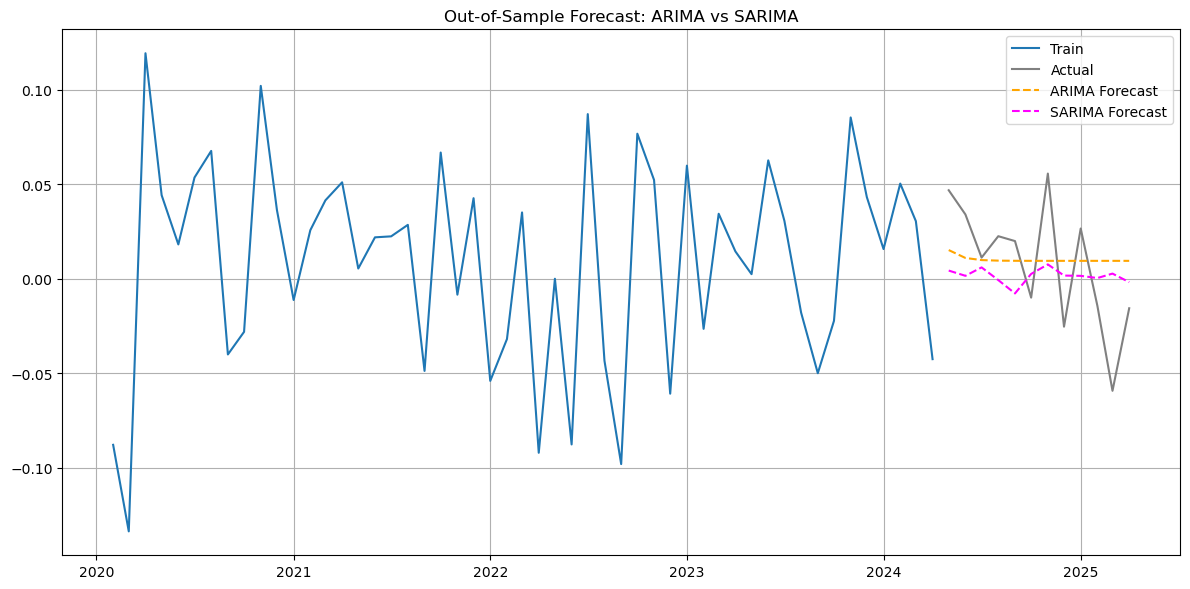

In [64]:
# week 4

# generate out of sample forecasts from ARIMA & SARIMA models

# split the data into testing and training 
train = sp500_data['Log Return'][:-12] 
test = sp500_data['Log Return'][-12:] # last 12 months

# fit ARIMA model w/ training data
arima_model = ARIMA(train, order=(1, 0, 1))
arima_result = arima_model.fit()

# forecast ARIMA
arima_forecast = arima_result.forecast(steps=12)

# fit SARIMA model
sarima_model = SARIMAX(train, order=(1, 0, 1), seasonal_order=(1, 0, 1, 12))
sarima_result = sarima_model.fit(disp=False)

# forecast SARIMA
sarima_forecast = sarima_result.forecast(steps=12)

# plot forecasts
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Actual', color='grey')
plt.plot(test.index, arima_forecast, label='ARIMA Forecast', linestyle='--', color='orange')
plt.plot(test.index, sarima_forecast, label='SARIMA Forecast', linestyle='--', color='magenta')
plt.title('Out-of-Sample Forecast: ARIMA vs SARIMA')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

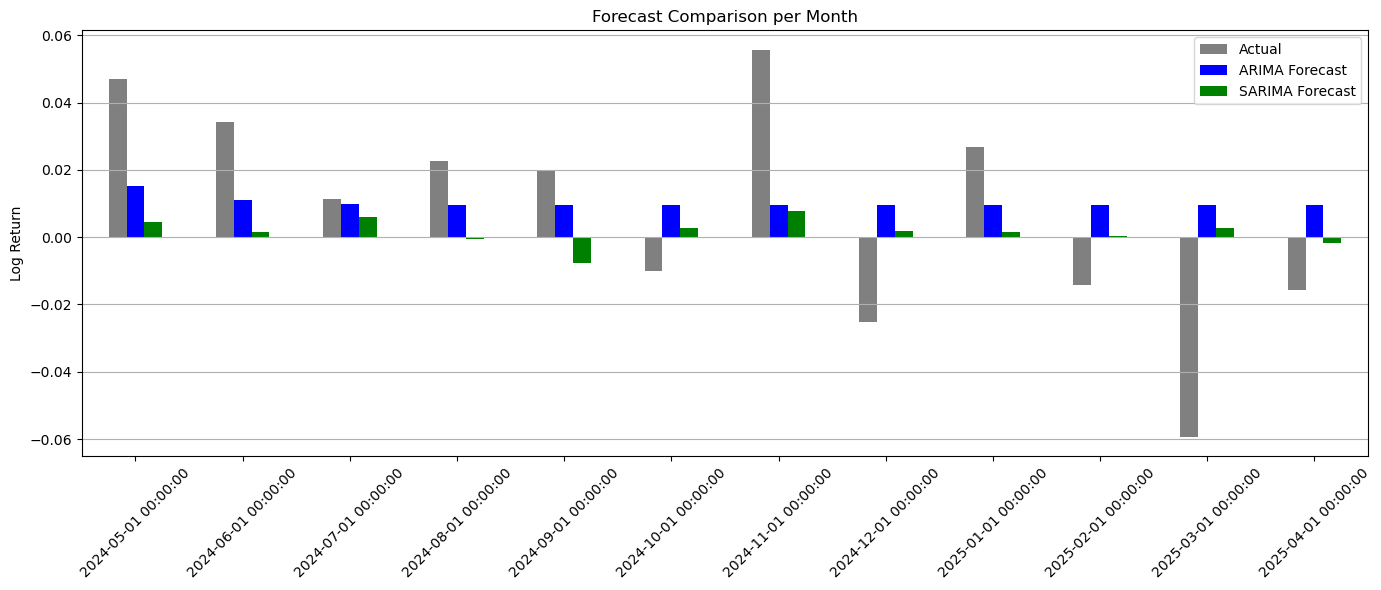

In [65]:
# plot monthly forecast comparisons

df_compare = pd.DataFrame({
    'Actual': test,
    'ARIMA Forecast': arima_forecast,
    'SARIMA Forecast': sarima_forecast
})

df_compare.plot(kind='bar', figsize=(14, 6), color=['grey', 'blue', 'green'])
plt.title('Forecast Comparison per Month')
plt.ylabel('Log Return')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis='y')
plt.show()

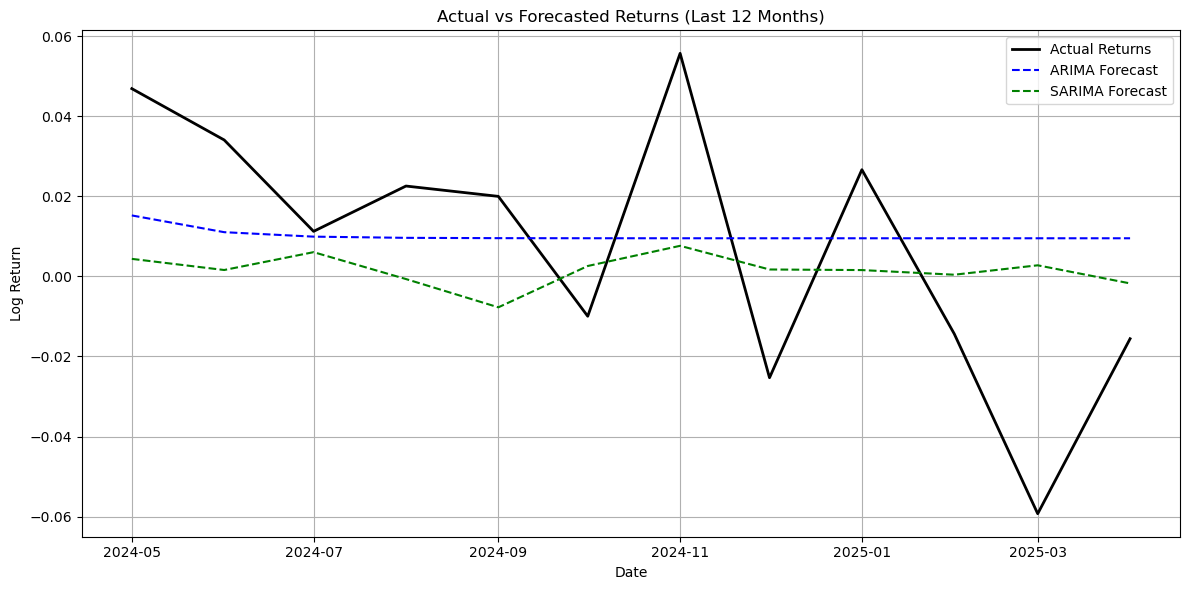

In [66]:
# actuals vs forecasted results plot

plt.figure(figsize=(12, 6))

# actual
plt.plot(test.index, test, label='Actual Returns', color='black', linewidth=2)

# ARIMA forecast
plt.plot(test.index, arima_forecast, label='ARIMA Forecast', color='blue', linestyle='--')

# SARIMA forecast
plt.plot(test.index, sarima_forecast, label='SARIMA Forecast', color='green', linestyle='--')

plt.title('Actual vs Forecasted Returns (Last 12 Months)')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [67]:
# evaluate forcasting accuracy using MAE and RMSE

# ARIMA accuracy
arima_mae = mean_absolute_error(test, arima_forecast)
arima_rmse = np.sqrt(mean_squared_error(test, arima_forecast))

# SARIMA accuracy
sarima_mae = mean_absolute_error(test, sarima_forecast)
sarima_rmse = np.sqrt(mean_squared_error(test, sarima_forecast))

print("Forecast Accuracy (last 12 months):")
print(f"ARIMA MAE: {arima_mae:.5f}")
print(f"ARIMA RMSE: {arima_rmse:.5f}")
print()
print(f"SARIMA MAE: {sarima_mae:.5f}")
print(f"SARIMA RMSE: {sarima_rmse:.5f}")

Forecast Accuracy (last 12 months):
ARIMA MAE: 0.02623
ARIMA RMSE: 0.03131

SARIMA MAE: 0.02788
SARIMA RMSE: 0.03200


**Analysis:**


ARIMA outperforms SARIMA in forecast accuracy, with a lower MAE (0.02623) and RMSE (0.03131) compared to SARIMA's MAE (0.02788) and RMSE (0.03200). However, both models show relatively low levels of forecasting error overall, suggesting that either model performs reasonably well, but ARIMA provides slightly more accurate predictions in the last 12 months.



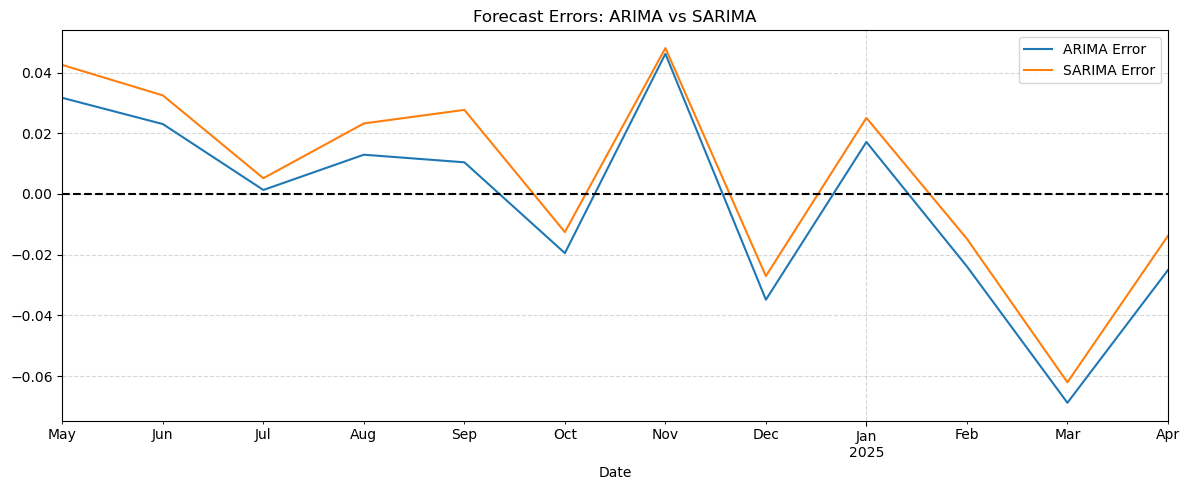

In [68]:
# plot forecast errors for ARIMA & SARIMA

errors = pd.DataFrame({
    'ARIMA Error': test - arima_forecast,
    'SARIMA Error': test - sarima_forecast
})

errors.plot(figsize=(12, 5), title='Forecast Errors: ARIMA vs SARIMA')
plt.axhline(0, color='black', linestyle='--')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()